In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =1e-24

nband = 100

ng =6

ng_adju = (/ -1 /) 

ng_refs = (/ 2 , 4 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.8 , 0.8 , 0.8 , 0.6,
     &     0.6 , 0.9/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

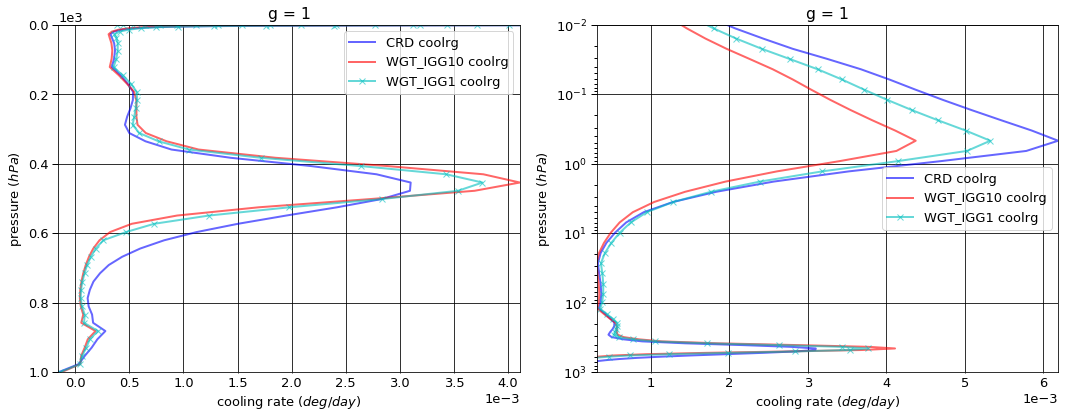

# Figure: cooling rate g-group 2

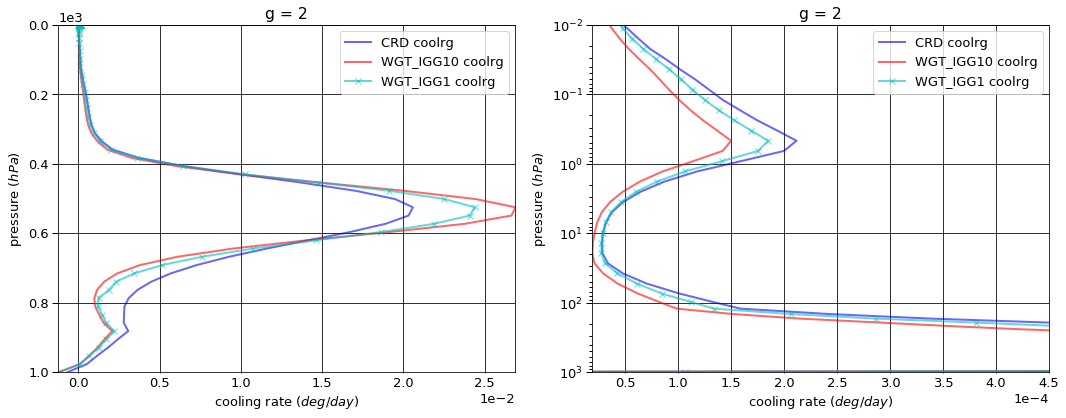

# Figure: cooling rate g-group 3

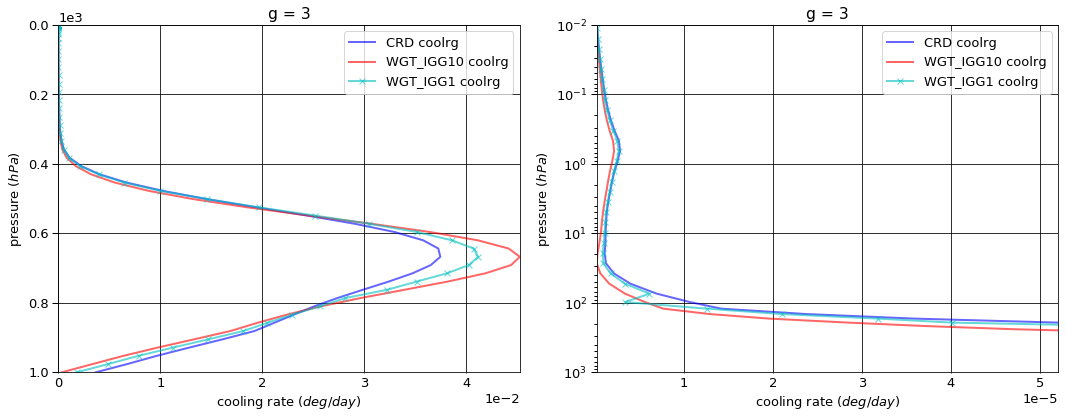

# Figure: cooling rate g-group 4

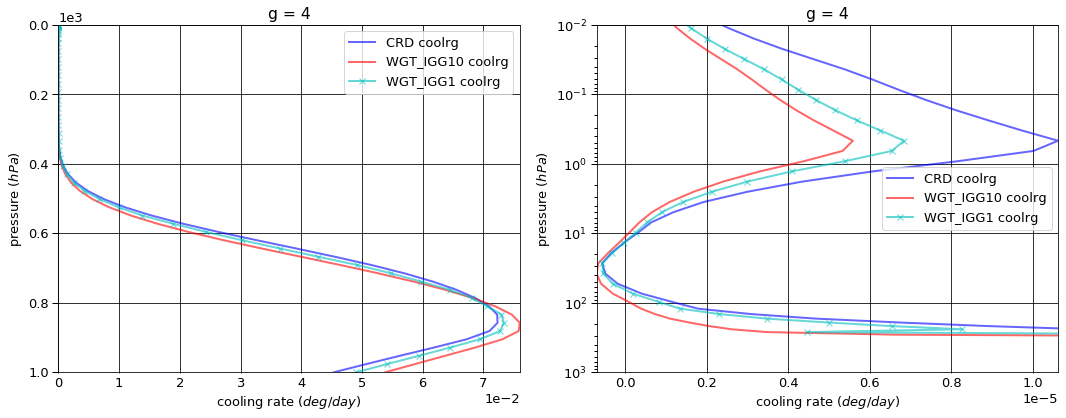

# Figure: cooling rate g-group 5

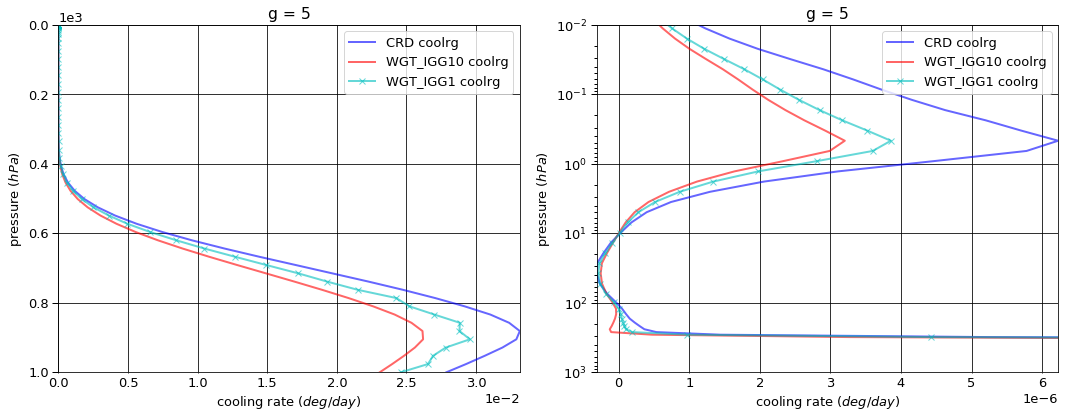

# Figure: cooling rate g-group 6

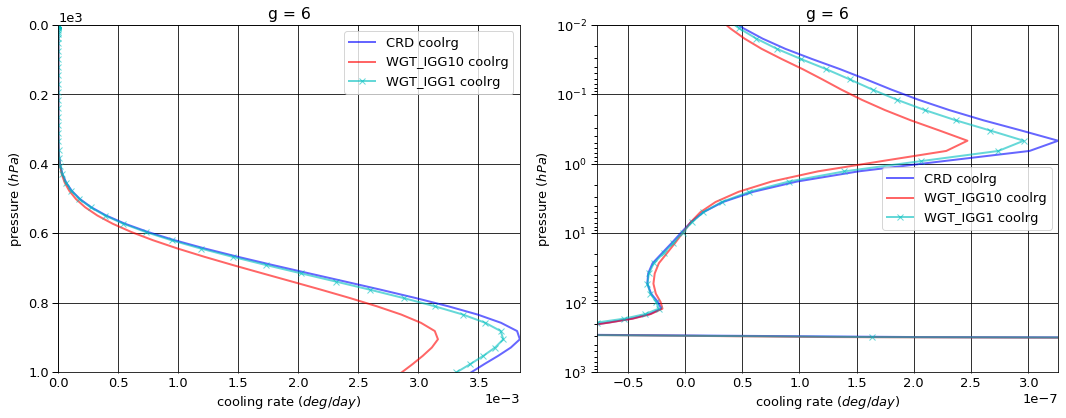

# Figure: cooling rate g-group total

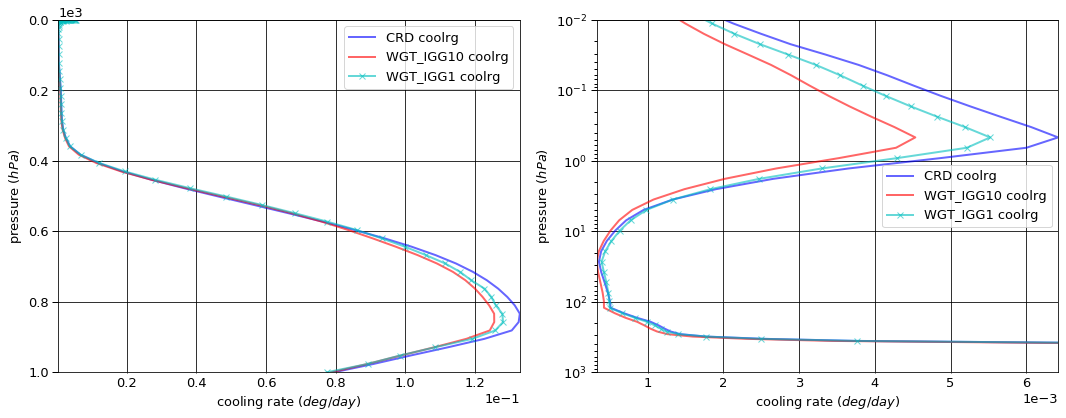

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.095556  0.000000  -0.095556
  1013.0   76     -0.149575  0.150461   0.000886
2 0.0      1      -0.654464  0.000000  -0.654464
  1013.0   76     -0.851195  0.849543  -0.001652
3 0.0      1      -1.633296  0.000000  -1.633296
  1013.0   76     -1.821523  1.752848  -0.068675
4 0.0      1      -6.433581  0.000000  -6.433581
  1013.0   76     -6.560790  3.172994  -3.387795
5 0.0      1     -11.649599  0.000000 -11.649599
  1013.0   76    -11.680886  1.296915 -10.383971
6 0.0      1      -5.970232  0.000000  -5.970232
  1013.0   76     -5.973250  0.145394  -5.827856


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.090935  0.000000  -0.090935
  1013.0   76     -0.149575  0.150084   0.000509
2 0.0      1      -0.639814  0.000000  -0.639814
  1013.0   76     -0.851195  0.857878   0.006683
3 0.0      1      -1.625303  0.000000  -1.625303
  1013.0   76     -1.821523  1.833068   0.011545
4 0.0      1      -6.462303  0.000000  -6.462303
  1013.0   76     -6.560790  3.135410  -3.425380
5 0.0      1     -11.658037  0.000000 -11.658037
  1013.0   76    -11.680886  1.012560 -10.668326
6 0.0      1      -5.970790  0.000000  -5.970790
  1013.0   76     -5.973250  0.119283  -5.853967


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.091485  0.000000  -0.091485
  1013.0   76     -0.149575  0.150162   0.000586
2 0.0      1      -0.640715  0.000000  -0.640715
  1013.0   76     -0.851195  0.858377   0.007181
3 0.0      1      -1.624164  0.000000  -1.624164
  1013.0   76     -1.821523  1.809582  -0.011941
4 0.0      1      -6.445318  0.000000  -6.445318
  1013.0   76     -6.560790  3.144897  -3.415892
5 0.0      1     -11.653035  0.000000 -11.653035
  1013.0   76    -11.680886  1.142521 -10.538365
6 0.0      1      -5.970275  0.000000  -5.970275
  1013.0   76     -5.973250  0.140589  -5.832660


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.621254e-03  0.000000  0.004621
  1013.0   76    -2.775558e-17 -0.000377 -0.000377
2 0.0      1      1.465024e-02  0.000000  0.014650
  1013.0   76     0.000000e+00  0.008335  0.008335
3 0.0      1      7.993800e-03  0.000000  0.007994
  1013.0   76    -2.220446e-16  0.080220  0.080220
4 0.0      1     -2.872270e-02  0.000000 -0.028723
  1013.0   76     0.000000e+00 -0.037584 -0.037584
5 0.0      1     -8.438000e-03  0.000000 -0.008438
  1013.0   76     0.000000e+00 -0.284355 -0.284355
6 0.0      1     -5.574000e-04  0.000000 -0.000557
  1013.0   76     0.000000e+00 -0.026111 -0.026111


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.071352e-03  0.000000  0.004071
  1013.0   76    -2.775558e-17 -0.000299 -0.000299
2 0.0      1      1.374902e-02  0.000000  0.013749
  1013.0   76     0.000000e+00  0.008834  0.008834
3 0.0      1      9.132600e-03  0.000000  0.009133
  1013.0   76    -2.220446e-16  0.056734  0.056734
4 0.0      1     -1.173720e-02  0.000000 -0.011737
  1013.0   76     0.000000e+00 -0.028097 -0.028097
5 0.0      1     -3.436000e-03  0.000000 -0.003436
  1013.0   76     0.000000e+00 -0.154394 -0.154394
6 0.0      1     -4.240000e-05  0.000000 -0.000042
  1013.0   76     0.000000e+00 -0.004805 -0.004805

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      3.985284e-04
  1001.112500 75    -1.569135e-04
2 0.000312    1      5.721525e-06
  1001.112500 75    -6.898766e-04
3 0.000312    1     -4.563098e-09
  1001.112500 75     3.672197e-03
4 0.000312    1     -3.307405e-07
  1001.112500 75     4.535173e-02
5 0.000312    1     -1.877354e-07
  1001.112500 75     2.786257e-02
6 0.000312    1     -1.051914e-08
  1001.112500 75     3.441343e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.982473e-04
  1001.112500 75    -1.308465e-04
2 0.000312    1      4.656267e-06
  1001.112500 75    -1.229686e-03
3 0.000312    1     -1.591080e-09
  1001.112500 75     3.478426e-04
4 0.000312    1     -2.100346e-07
  1001.112500 75     5.382642e-02
5 0.000312    1     -1.041347e-07
  1001.112500 75     2.307774e-02
6 0.000312    1     -6.976736e-09
  1001.112500 75     2.862581e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.866292e-04
  1001.112500 75    -1.454990e-04
2 0.000312    1      7.163403e-06
  1001.112500 75    -1.203239e-03
3 0.000312    1      7.409030e-09
  1001.112500 75     1.808706e-03
4 0.000312    1     -1.954087e-07
  1001.112500 75     4.904132e-02
5 0.000312    1     -1.203217e-07
  1001.112500 75     2.459164e-02
6 0.000312    1     -8.357674e-09
  1001.112500 75     3.318614e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.002812e-04
  1001.112500 75     2.606696e-05
2 0.000312    1     -1.065258e-06
  1001.112500 75    -5.398093e-04
3 0.000312    1      2.972017e-09
  1001.112500 75    -3.324354e-03
4 0.000312    1      1.207059e-07
  1001.112500 75     8.474696e-03
5 0.000312    1      8.360075e-08
  1001.112500 75    -4.784823e-03
6 0.000312    1      3.542405e-09
  1001.112500 75    -5.787624e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.189926e-05
  1001.112500 75     1.141453e-05
2 0.000312    1      1.441877e-06
  1001.112500 75    -5.133627e-04
3 0.000312    1      1.197213e-08
  1001.112500 75    -1.863490e-03
4 0.000312    1      1.353319e-07
  1001.112500 75     3.689597e-03
5 0.000312    1      6.741376e-08
  1001.112500 75    -3.270932e-03
6 0.000312    1      2.161467e-09
  1001.112500 75    -1.227293e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.436729,0.000000,-26.436729
1013.0,76,-27.037219,7.368155,-19.669063



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.447182,0.000000,-26.447182
1013.0,76,-27.037219,7.108284,-19.928935



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.424991,0.000000,-26.424991
1013.0,76,-27.037219,7.246128,-19.791091



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.010453,0.000000,-0.010453
1013.0,76,0.000000,-0.259872,-0.259872



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.011737,0.000000,0.011737
1013.0,76,0.000000,-0.122027,-0.122027


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000404
1001.112500,75,0.079481



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000303
1001.112500,75,0.078754



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000393
1001.112500,75,0.077412



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000101
1001.112500,75,-0.000727



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.00001
1001.112500,75,-0.00207


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00547,0.005540
2,0.03123,0.031512
3,0.06677,0.067444
4,0.24074,0.242887
5,0.43031,0.432220
6,0.22548,0.220397


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.453395e-21
2,1.001262e-22
3,6.829959e-23
4,8.264363e-24
5,1.000002e-24
6,1.306671e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.453395e-21,NaN,0.00547,0.005540,0.00547,0.005540,100.0
2,1.001262e-22,0.040811,0.03123,0.031512,0.03670,0.037052,100.0
3,6.829959e-23,0.682135,0.06677,0.067444,0.10347,0.104496,600.0
4,8.264363e-24,0.121002,0.24074,0.242887,0.34421,0.347382,600.0
5,1.000002e-24,0.121002,0.43031,0.432220,0.77452,0.779603,600.0
6,1.306671e-25,0.130667,0.22548,0.220397,1.00000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
